In [8]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py /kaggle/working
!cp vision/references/detection/transforms.py /kaggle/working
!cp vision/references/detection/coco_eval.py /kaggle/working
!cp vision/references/detection/engine.py /kaggle/working
!cp vision/references/detection/coco_utils.py /kaggle/working

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mlepf26v
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-mlepf26v
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279394 sha256=918db69ea73ac3bdb8d6d9487a1b878f77ccbf0ff16e25d6bdf078cfb49df6bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ffqav1m/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Cloning into 'vision'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 9275 (delta 5), reused 2 (delta 0), pack-reused 9258
Receiving objects: 100% (9275/9275), 11.24 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (6424/6424), done.


In [10]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

from albumentations import *
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Global Wheat Detection Dataset

This challenge aims to develop a generic model to identify wheat heads from high resolution images. This model will enable us to
* Do high quality reseach about the techniques of growing wheat
* Aid farmers to maintain very large amount of crops by observing different stages, detecting diseases and to verify the quality.

I have tried to develop such a model in this notebook; but first let us look at the data.

In [271]:
from glob import glob
import matplotlib.patches as patches
import seaborn as sns
# Setup the paths to train and test images
TRAIN_DIR = '../input/global-wheat-detection/train/'
TEST_DIR = '../input/global-wheat-detection/test/'
TRAIN_CSV_PATH = '../input/global-wheat-detection/train.csv'

# Glob the directories and get the lists of train and test images
train_fns = glob(TRAIN_DIR + '*')
test_fns = glob(TEST_DIR + '*')

Number of images in train and test data

In [272]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


Train images consist of 3422 sample, which is quite low for building a generic model. We have to use data agumentation in order to make the model more robust.

In [230]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [304]:
train_df_sample = train_df[1:]

In [293]:
def plot_image_examples(df, rows=2, cols=2, title='Image examples', box = True):
    fig, axs = plt.subplots(rows, cols, figsize=(16,16))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].set_title(img_id)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            if box == True:
                for bbox in bboxes:
                    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                    axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
            
    plt.suptitle(title)

#### Some example of Train Images:

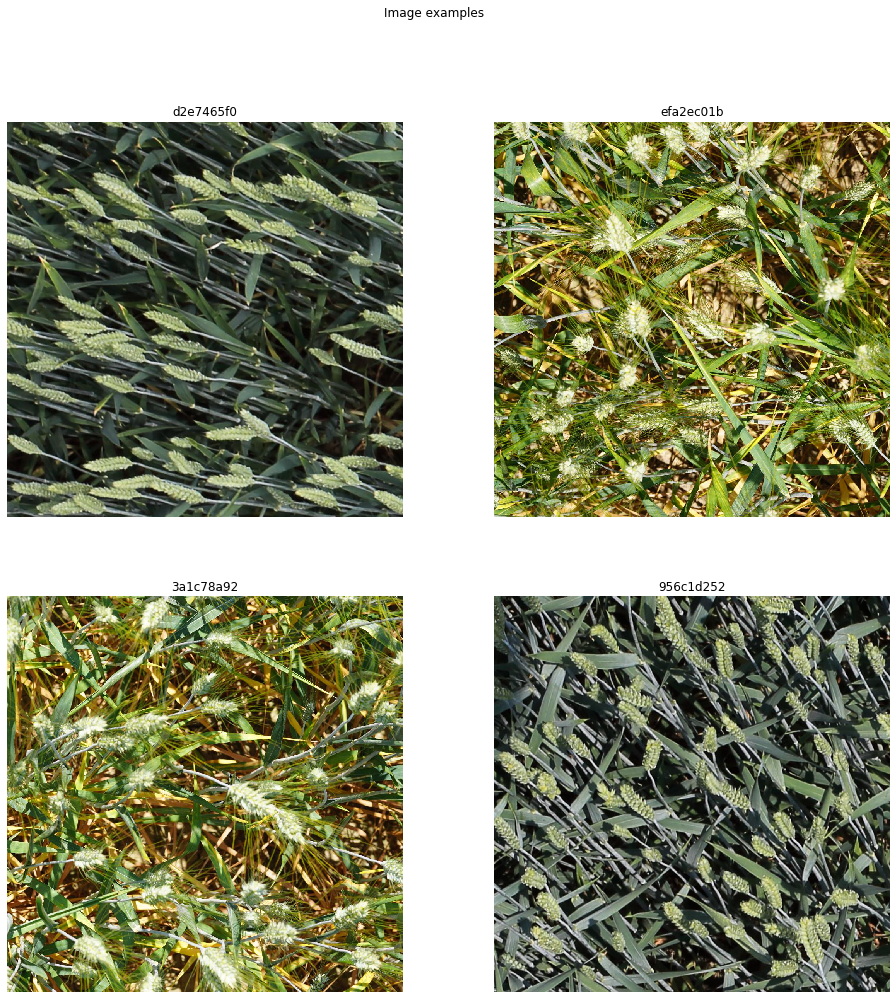

In [298]:
plot_image_examples(train_df_sample, box = False)

In [299]:
train_df_sample['count'] = train_df_sample.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = train_df_sample.groupby('image_id').sum().reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Lets look at some of the different samples present in the dataset

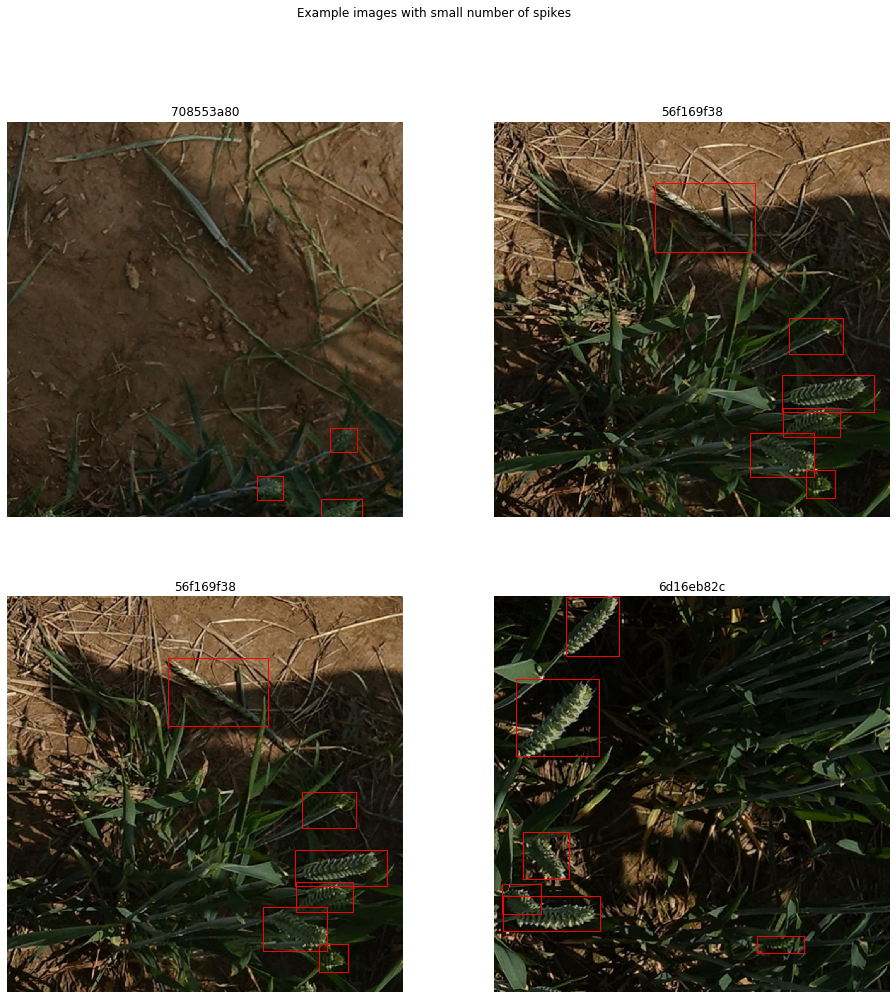

In [301]:
less_spikes_ids = train_images_count[train_images_count['count'] < 10].image_id
plot_image_examples(train_df_sample[train_df_sample.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')

These images are not good for sampling. They mostly show the grounds and they seem to bee zoomed awkwardly.

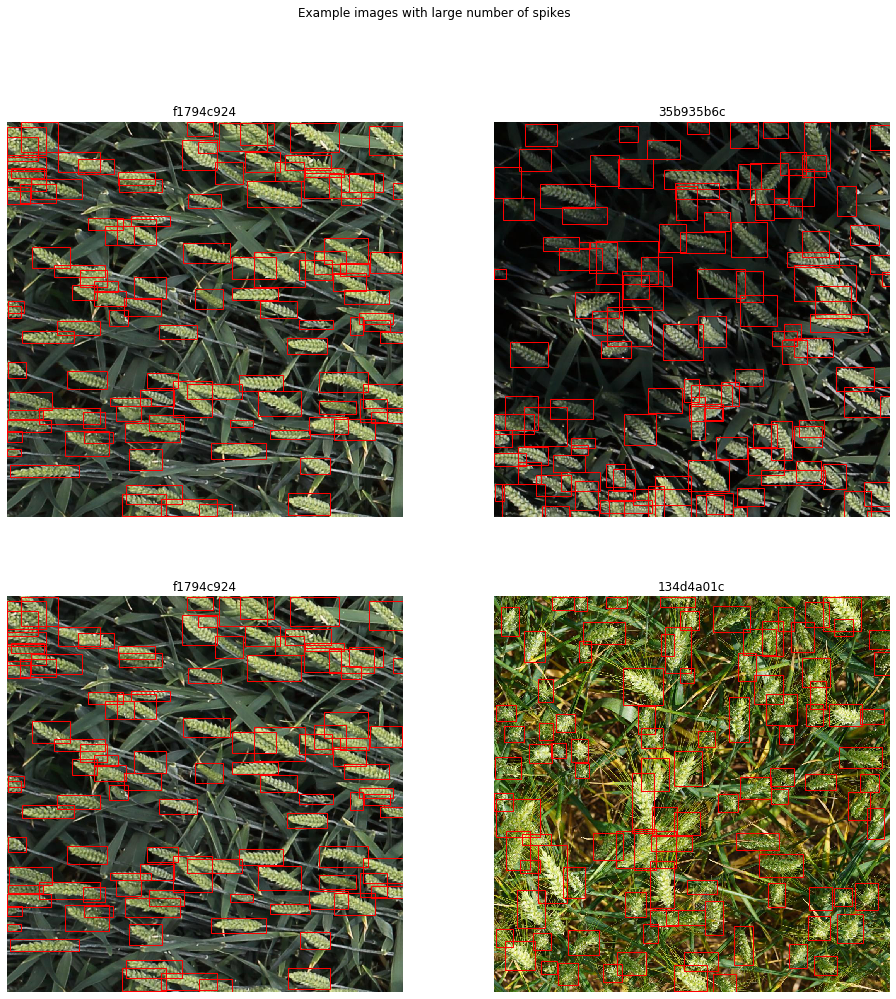

In [303]:
many_spikes_ids = train_images_count[train_images_count['count'] > 100].image_id
plot_image_examples(train_df_sample[train_df_sample.image_id.isin(many_spikes_ids)], title='Example images with large number of spikes')

Now this looks nice.

# Data Preparation

In [228]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.as_tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]


### Augmenting the data

In [229]:
# Albumentations
def get_train_transform():
    return Compose(
        [OneOf([HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                   val_shift_limit=0.2, p=0.9),
                RandomBrightnessContrast(brightness_limit=0.2,
                                         contrast_limit=0.2, p=0.9)],
               p=0.9),
            ToGray(p=0.01),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)],
        p=1.0,
        bbox_params=BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )
def get_valid_transform():
    return Compose(
        [
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [232]:
def collate_fn(batch):
    return tuple(zip(*batch))
dataset_train = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
dataset_valid = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=8, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid, batch_size=4, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Model creation.
Here i am using a pretrained version of FasterRCNN with the Feature Pyramid Network

In [233]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#     model.load_state_dict(torch.load(PATH))
    
    return model

In [234]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### Training Module.
This trains the dataset for one epoch. We will get our loss from here

In [235]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

loss_hist = Averager()
def train_one_epoch_custom(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    loss_hist.reset()
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
            
        loss_hist.send(loss_value)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger, loss_hist

In [238]:
from engine import train_one_epoch, evaluate
import utils

def train():
    num_classes = 2
    
    dataset_train = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
    dataset_valid = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
    model = get_model(num_classes)
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    num_epochs = 15
    
    loss_list = []
    for epoch in range(num_epochs):
        # train for one epoch, printing every 300 iterations
        _,loss=train_one_epoch_custom(model, optimizer, data_loader_train, device, epoch, print_freq=300)
        loss_list.append((epoch,loss.value))
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the validation dataset
        evaluate(model, data_loader_valid, device=device)
        
    
    
    print("Saving the model.......")
    PATH = '/kaggle/working/wheatFasterRCNNepoch15.pth'
    torch.save(model.state_dict(), PATH)
    print("That's it")
    return model, loss_list

In [239]:
model, loss = train()

Epoch: [0]  [  0/339]  eta: 0:23:50  lr: 0.000020  loss: 5.1686 (5.1686)  loss_classifier: 0.6429 (0.6429)  loss_box_reg: 0.3685 (0.3685)  loss_objectness: 3.8824 (3.8824)  loss_rpn_box_reg: 0.2748 (0.2748)  time: 4.2209  data: 2.7339  max mem: 11894
Epoch: [0]  [300/339]  eta: 0:00:42  lr: 0.004453  loss: 0.7126 (0.9991)  loss_classifier: 0.2531 (0.3200)  loss_box_reg: 0.2481 (0.3045)  loss_objectness: 0.0813 (0.2075)  loss_rpn_box_reg: 0.1448 (0.1671)  time: 1.0598  data: 0.0434  max mem: 12163
Epoch: [0]  [338/339]  eta: 0:00:01  lr: 0.005000  loss: 0.7046 (0.9684)  loss_classifier: 0.2483 (0.3125)  loss_box_reg: 0.2385 (0.2975)  loss_objectness: 0.0672 (0.1929)  loss_rpn_box_reg: 0.1477 (0.1656)  time: 1.0131  data: 0.0417  max mem: 12163
Epoch: [0] Total time: 0:06:03 (1.0734 s / it)
creating index...
index created!
Test:  [  0/167]  eta: 0:04:45  model_time: 0.2570 (0.2570)  evaluator_time: 0.6519 (0.6519)  time: 1.7099  data: 0.6513  max mem: 12163
Test:  [100/167]  eta: 0:01:05

Test:  [166/167]  eta: 0:00:00  model_time: 0.1895 (0.1910)  evaluator_time: 0.2646 (0.5154)  time: 0.5123  data: 0.0195  max mem: 12163
Test: Total time: 0:02:08 (0.7689 s / it)
Averaged stats: model_time: 0.1895 (0.1910)  evaluator_time: 0.2646 (0.5154)
Accumulating evaluation results...
DONE (t=0.70s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50

Epoch: [7]  [  0/339]  eta: 0:22:59  lr: 0.000050  loss: 0.5536 (0.5536)  loss_classifier: 0.1913 (0.1913)  loss_box_reg: 0.1952 (0.1952)  loss_objectness: 0.0361 (0.0361)  loss_rpn_box_reg: 0.1310 (0.1310)  time: 4.0697  data: 2.6902  max mem: 12163
Epoch: [7]  [300/339]  eta: 0:00:42  lr: 0.000050  loss: 0.5947 (0.6108)  loss_classifier: 0.2140 (0.2171)  loss_box_reg: 0.2183 (0.2117)  loss_objectness: 0.0442 (0.0507)  loss_rpn_box_reg: 0.1257 (0.1314)  time: 1.0555  data: 0.0444  max mem: 12163
Epoch: [7]  [338/339]  eta: 0:00:01  lr: 0.000050  loss: 0.5891 (0.6110)  loss_classifier: 0.2070 (0.2165)  loss_box_reg: 0.2043 (0.2116)  loss_objectness: 0.0455 (0.0510)  loss_rpn_box_reg: 0.1316 (0.1318)  time: 1.0294  data: 0.0429  max mem: 12163
Epoch: [7] Total time: 0:06:04 (1.0749 s / it)
creating index...
index created!
Test:  [  0/167]  eta: 0:04:06  model_time: 0.2689 (0.2689)  evaluator_time: 0.3679 (0.3679)  time: 1.4740  data: 0.7407  max mem: 12163
Test:  [100/167]  eta: 0:00:57

Test:  [166/167]  eta: 0:00:00  model_time: 0.1912 (0.1932)  evaluator_time: 0.2670 (0.5160)  time: 0.5080  data: 0.0205  max mem: 12163
Test: Total time: 0:02:09 (0.7750 s / it)
Averaged stats: model_time: 0.1912 (0.1932)  evaluator_time: 0.2670 (0.5160)
Accumulating evaluation results...
DONE (t=0.74s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.879
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50

Epoch: [14]  [  0/339]  eta: 0:22:56  lr: 0.000001  loss: 0.6017 (0.6017)  loss_classifier: 0.2160 (0.2160)  loss_box_reg: 0.2161 (0.2161)  loss_objectness: 0.0410 (0.0410)  loss_rpn_box_reg: 0.1286 (0.1286)  time: 4.0603  data: 2.6915  max mem: 12163
Epoch: [14]  [300/339]  eta: 0:00:42  lr: 0.000001  loss: 0.6060 (0.6134)  loss_classifier: 0.2161 (0.2173)  loss_box_reg: 0.2105 (0.2112)  loss_objectness: 0.0461 (0.0522)  loss_rpn_box_reg: 0.1326 (0.1327)  time: 1.0611  data: 0.0411  max mem: 12163
Epoch: [14]  [338/339]  eta: 0:00:01  lr: 0.000001  loss: 0.5820 (0.6118)  loss_classifier: 0.2122 (0.2171)  loss_box_reg: 0.2024 (0.2111)  loss_objectness: 0.0461 (0.0517)  loss_rpn_box_reg: 0.1239 (0.1319)  time: 1.0123  data: 0.0401  max mem: 12163
Epoch: [14] Total time: 0:06:04 (1.0741 s / it)
creating index...
index created!
Test:  [  0/167]  eta: 0:04:08  model_time: 0.2900 (0.2900)  evaluator_time: 0.3521 (0.3521)  time: 1.4862  data: 0.7216  max mem: 12163
Test:  [100/167]  eta: 0:0

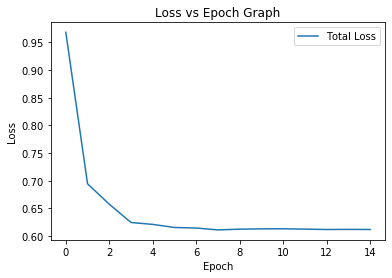

In [250]:
fig, ax = plt.subplots()
ax.plot([i[0] for i in loss], [i[1] for i in loss], label = "Total Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch Graph")
ax.legend()

In [251]:
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

### Testing

In [252]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [253]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
def get_test_transform():
    return Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x, row.y, row.w, row.h))
        
    return bboxes

In [254]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [255]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [258]:
detection_threshold = 0.5
results = []
results1 = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        for elem in zip(scores, boxes):
            result1 = {
            'image_id': image_id,
            'score' : elem[0],
            'x': elem[1][0],
            'y': elem[1][1],
            'w': elem[1][2],
            'h': elem[1][3]
        }
            results1.append(result1)
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)
test_df = pd.DataFrame(results1, columns=['image_id', 'score', 'x', 'y', 'w', 'h'])
final_test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])

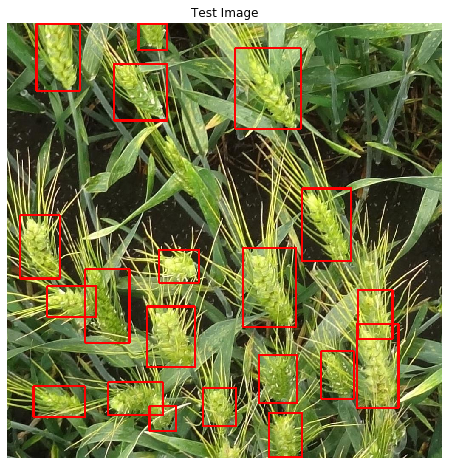

In [265]:
images, image_ids = next(iter(test_data_loader))
idx = image_ids[0]
pred_boxes = get_all_bboxes(test_df, idx)
image = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16,8))
for pred_box in pred_boxes:
        cv2.rectangle(
            image,
            (pred_box[0], pred_box[1]),
            (pred_box[2]+pred_box[0], pred_box[3]+pred_box[1]),
            (220, 0, 0), 3)
ax.set_title("Test Image")
ax.set_axis_off()
ax.imshow(image)


In [266]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{DIR_TRAIN}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 3)

    for gt_box in gt_boxes:
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]),
            (0, 0, 220), 3)
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("Comparison on Validation Image | RED: Predicted | BLUE - Ground-truth")

In [268]:
test_images, test_image_ids = next(iter(data_loader_valid))
test_images = list(image.to(device) for image in test_images)
outputs = model(test_images)
sample = test_images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

idx = valid_df['image_id'].unique()[1]
gt_boxes = get_all_bboxes(valid_df, idx)
gt_boxes = [[int(i) for i in elem] for elem in gt_boxes]

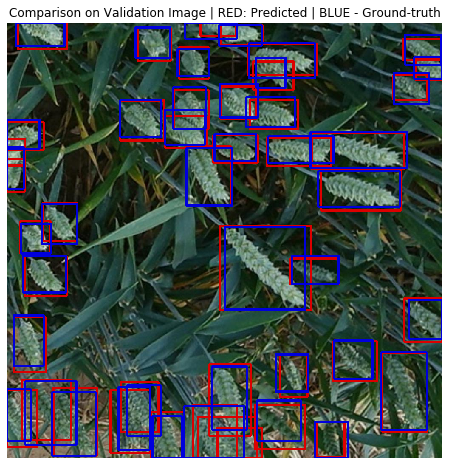

In [269]:
show_result(idx,boxes, gt_boxes)

In [270]:
final_test_df

image_id                                   PredictionString
0  aac893a91  0.9909 69 2 102 157 0.9883 555 529 125 186 0.9...
1  51f1be19e  0.9868 610 91 156 169 0.9778 506 471 197 103 0...
2  f5a1f0358  0.9886 889 644 82 141 0.9831 943 431 79 182 0....
3  796707dd7  0.9808 942 74 79 100 0.9767 897 333 98 87 0.97...
4  51b3e36ab  0.9959 828 453 196 148 0.9947 234 644 95 157 0...
5  348a992bb  0.9946 735 223 133 86 0.9911 539 35 79 94 0.99...
6  cc3532ff6  0.9950 771 825 169 161 0.9932 263 644 100 161 ...
7  2fd875eaa  0.9972 104 581 141 88 0.9941 455 498 86 134 0....
8  cb8d261a3  0.9888 22 559 180 102 0.9777 587 36 79 85 0.97...
9  53f253011  0.9970 928 200 96 139 0.9952 467 465 151 195 0...